In [138]:
import pickle as pkl
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
import pickle as pkl

import json    
import configparser
%matplotlib inline

config = configparser.ConfigParser()
config.read(os.path.join('.',"vk_crawl","config.ini"))
data_path = config['general']['DataPath']
sns.set_style("whitegrid")

In [3]:
reposts = pkl.load(open(os.path.join(data_path, 'reposts.pkl'), "rb"))
posts = pkl.load(open(os.path.join(data_path, 'collected_posts.pkl'), "rb"))
len(reposts), len(posts), len(reposts)/len(posts)

(85199, 509887, 0.1670938855079655)

In [4]:
len(posts[posts['owner_id'] < 0]), len(posts['owner_id'].unique())

(461289, 20634)

In [5]:
G_with_posts = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_filtered_nodes_with_posts.pkl'))

In [12]:
g = next(nx.connected_components(G_with_posts))
len(g)

2452

In [30]:
nx.average_clustering(trueGraphWithPosts)

0.12048740975064526

In [35]:
np.mean([trueGraphWithPosts.degree(k) for k in trueGraphWithPosts])

22.92659053833605

In [36]:
dd = [trueGraphWithPosts.degree(k) for k in trueGraphWithPosts]

In [40]:
np.max(dd)

381

In [41]:
plt.set_yscale('log')
plt.hist(dd, bins=30)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_yscale'

In [37]:
trueGraphWithPosts = G_with_posts.subgraph(GG)

In [20]:
GG = g

In [22]:
posts_in_graph = posts[posts['owner_id'].isin(GG)]

In [23]:
len(posts_in_graph)

106217

In [45]:
posts[posts['owner_id'] > 0].groupby('owner_id')['text'].count().value_counts().head()

1    2445
2     822
3     495
4     346
5     227
Name: text, dtype: int64

In [5]:
a = posts[posts['owner_id'] > 0].groupby('owner_id')['text'].count()

In [8]:
a[a<10].sum()/48598

0.257664924482489

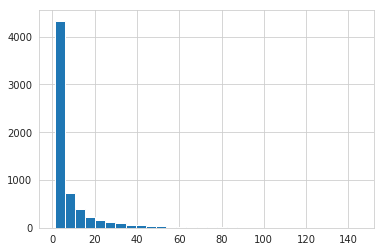

In [6]:
a.hist(bins=30)

In [78]:
a = a[a > 10]
len(a)

1301

In [ ]:
posts[posts['owner_id'].isin(set(a.index))]

In [65]:
a = a[a >= 100]
len(a), a.sum()

(5, 595)

In [21]:
a = pd.Series(list(reposts.nodes()))

In [23]:
a[a < 0]

Series([], dtype: int64)

In [24]:
ids = pkl.load(open(os.path.join(config['general']['DataPath'], 'post_ids_index.pkl'), 'rb'))

In [26]:
a = pd.Series(ids)
a[a < 0]

Series([], dtype: int64)

In [24]:
matrix = pkl.load(open(os.path.join(config['general']['DataPath'], 'vectorized_posts_counter_matrix_all.pkl'), "rb"))
colmatrix = matrix.tocsc()
frequencies = []
term_count = matrix.shape[1]
for term_id in tqdm(range(term_count)):
    frequencies.append(len(colmatrix.getcol(term_id).nonzero()[0]))
s = pd.Series(frequencies)

100%|██████████| 236892/236892 [00:15<00:00, 14905.44it/s]


Text(0, 0.5, 'Document Frequency')

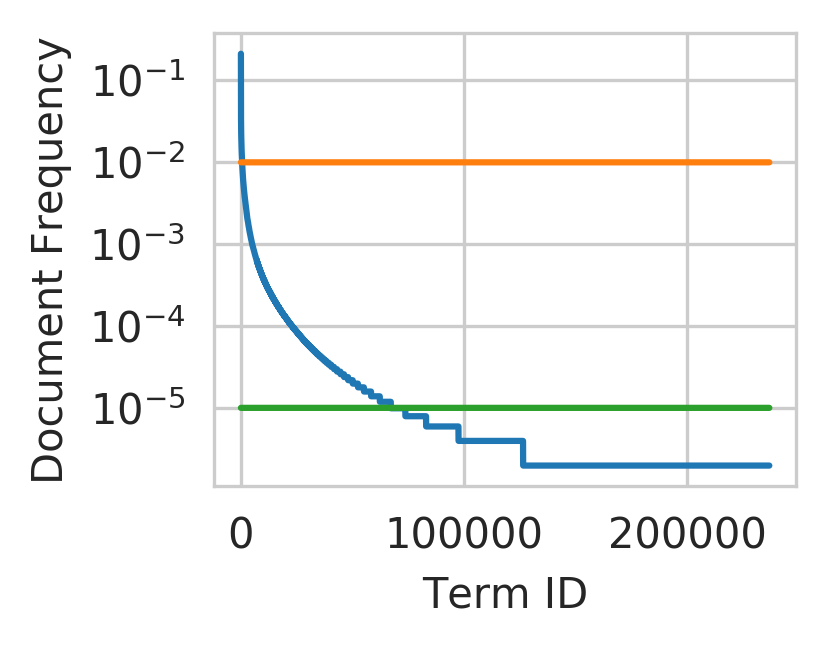

In [42]:
plt.figure(dpi=300, figsize=(2.5,2))
plt.semilogy(list(s[np.argsort(s)[0:]]/505857)[::-1])
plt.semilogy([5000/505857]*len(s))
plt.semilogy([10**(-5)]*len(s))
plt.xlabel('Term ID')
plt.ylabel('Document Frequency')

In [113]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_filtered_nodes_with_posts.pkl'))

In [115]:
nodes = pd.Series(list(g.nodes()))

In [116]:
len(nodes[nodes > 0]), len(nodes[nodes <0]), len(nodes)

(1386, 1974, 3360)

In [119]:
useruser = 0
usergroup = 0
groupgroup = 0
for e in g.edges():
    a = e[0]*e[1]
    if a < 0:
        usergroup += 1
    else:
        if e[0] < 0:
            groupgroup += 1
        else:
            useruser += 1
g.number_of_edges(), useruser, groupgroup, usergroup

(15554, 5795, 0, 9759)

In [9]:
# this loads 160G in memory, takes a while
new_tf_idf = np.load(os.path.join(config['general']['DataPath'], 'new_tf_idf.npy'))
posts_in_graph = pkl.load(open(os.path.join(config['general']['DataPath'], 'new_collected_posts.pkl'), "rb"))

In [31]:
a = new_tf_idf[:,0]

In [33]:
a = new_tf_idf[:,0]
a = pd.Series(a)
len(a), len(a[a==0]), len(a[a==0])/len(a)

(314722, 18855, 0.05991001582348866)

In [10]:
new_tf_idf.shape

(314722, 66664)

In [11]:
sample_indexes = np.random.choice(new_tf_idf.shape[0], 1000, replace=False)

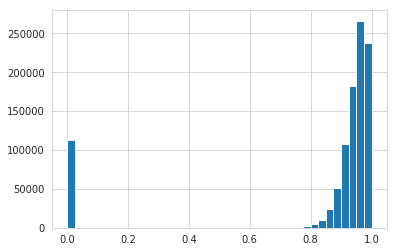

In [16]:
new_tf_idf_sample = new_tf_idf[sample_indexes,:]
proximity_sample = cosine_similarity(new_tf_idf_sample)
pd.Series(list((proximity_sample).reshape(1,len(sample_indexes)**2)[0])).hist(bins=40)

In [ ]:
for i in range(len(proximity_sample)):
    for j in range(len(proximity_sample)):
        if proximity_sample[i,j] < 0.999 and proximity_sample[i,j] > 0.997:
            post1 = posts_in_graph.iloc[sample_indexes[i]]['stemmed']
            post2 = posts_in_graph.iloc[sample_indexes[j]]['stemmed']
            if post1 != post2:
                print("{}: \n-----\n{}\n-----\n{}\n------\n------\n".format(proximity_sample[i,j], post1, post2))

# Training

In [43]:
rates = pkl.load(open(os.path.join(config['general']['DataPath'], 'rates.pkl'), "rb"))
# rates_train = pkl.load(open(os.path.join(config['general']['DataPath'], 'rates_train.pkl'), "rb"))

In [59]:
th = list(np.arange(0.7,0.98,0.005)) + list(np.arange(0.98,1,0.001))
auc = []
for i in tqdm(range(56,len(th)-2)):
    th_val = th[i]
    r = pd.DataFrame(np.array(rates[i]), columns=['success', 'failure', 'p'])
    
    recall = []
    falloff = []
    trials = r['success'].sum() + r['failure'].sum()
    for theta in np.linspace(0,1.000001,200):
        recall.append([theta, r[r['p'] >= theta]['success'].sum()/r['success'].sum()])
        falloff.append([theta, r[r['p'] >= theta]['failure'].sum()/r['failure'].sum()])
    recall = np.array(recall)
    falloff = np.array(falloff)
    x = falloff[:,1]
    y = recall[:,1]
    auc.append((th_val, -np.trapz(y, x=x)))

#plt.plot(np.linspace(0,1,400), np.linspace(0,1,400), linewidth=0.5)
auc = np.array(auc)

100%|██████████| 20/20 [00:11<00:00,  1.88it/s]


Text(0, 0.5, 'AUC')

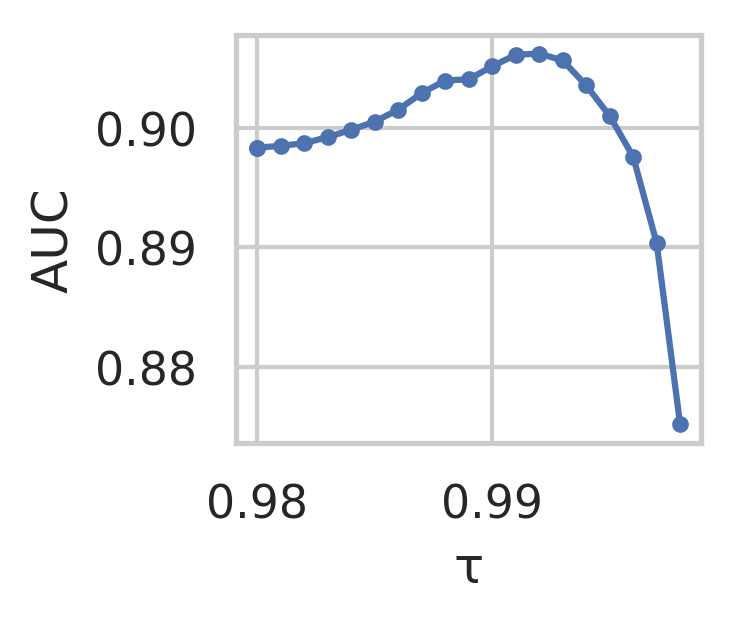

In [61]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2,1.8)},style="whitegrid")
plt.plot(auc[:,0], auc[:,1], marker=".")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("τ")
plt.ylabel("AUC")

In [62]:
auc

array([[0.98      , 0.89834482],
       [0.98      , 0.89834482],
       [0.981     , 0.89850848],
       [0.982     , 0.89872223],
       [0.983     , 0.89924049],
       [0.984     , 0.89985074],
       [0.985     , 0.90053414],
       [0.986     , 0.90154042],
       [0.987     , 0.9029257 ],
       [0.988     , 0.90397859],
       [0.989     , 0.90408721],
       [0.99      , 0.90516865],
       [0.991     , 0.90613999],
       [0.992     , 0.90623761],
       [0.993     , 0.90566355],
       [0.994     , 0.90357536],
       [0.995     , 0.9010112 ],
       [0.996     , 0.89760342],
       [0.997     , 0.89036317],
       [0.998     , 0.87516739]])

In [67]:
th[69]

0.992

In [63]:
weighted_Gs = pkl.load(open(os.path.join(config['general']['DataPath'], 'weighted_Gs.pkl'), "rb"))

In [223]:
posts_in_graph = pkl.load(open(os.path.join(config['general']['DataPath'], 'new_collected_posts.pkl'), "rb"))
len(posts_in_graph.groupby('owner_id')['text'].count())

3360

In [68]:
len(weighted_Gs[69])

2094

In [70]:
GGG = weighted_Gs[69]

In [71]:
nx.write_gpickle(GGG, os.path.join(config['general']['DataPath'], 'final_vk_graph.pkl'))

In [441]:
nx.write_edgelist(GGG, os.path.join(config['general']['DataPath'], 'final_vk_graph_edgelist.csv'), data=False)

In [18]:
for i in range(len(weighted_Gs)):
    print(i, len(weighted_Gs[i]))

0 2398
1 2398
2 2398
3 2398
4 2398
5 2398
6 2398
7 2398
8 2398
9 2398
10 2398
11 2398
12 2398
13 2398
14 2398
15 2398
16 2398
17 2398
18 2398
19 2398
20 2398
21 2398
22 2398
23 2398
24 2398
25 2398
26 2398
27 2398
28 2398
29 2398
30 2398
31 2398
32 2398
33 2398
34 2398
35 2398
36 2398
37 2398
38 2398
39 2398
40 2397
41 2397
42 2397
43 2397
44 2397
45 2397
46 2395
47 2394
48 2392
49 2390
50 2387
51 2385
52 2380
53 2376
54 2366
55 2352
56 2324
57 2324
58 2321
59 2311
60 2300
61 2291
62 2281
63 2269
64 2254
65 2229
66 2207
67 2179
68 2150
69 2094
70 2046
71 1975
72 1869
73 1740
74 1574
75 1332
76 940
77 302


In [262]:
G_with_posts = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_filtered_nodes_with_posts.pkl'))

In [263]:
len(G_with_posts)

4300

In [ ]:
matrix = pkl.load(open(os.path.join(config['general']['DataPath'], 'vectorized_posts_counter_matrix.pkl'), "rb"))

In [234]:
a = matrix.sum(axis=1)

In [ ]:
a = pd.Series(np.asarray(a).flatten())

In [248]:
posts = pkl.load(open(os.path.join(config['general']['DataPath'], 'collected_posts.pkl'), "rb"))

In [252]:
posts.shape, matrix.shape

((509887, 5), (509887, 66664))

In [253]:
posts['id_in_tfidf'] = np.arange(matrix.shape[0])

In [ ]:
missed = set()
for i in tqdm(list(a[a==0].index)):
    missed = missed.union(set(posts[posts['id_in_tfidf'] == i]['stemmed'].iloc[0].split()))

In [261]:
len(missed)

3698

In [229]:
posts_in_graph[posts_in_graph['id_in_tfidf'].isin(a[a>0].index)]

In [ ]:
missed = list(missed)
pkl.dump(missed, open(os.path.join(config['general']['DataPath'], 'words_not_in_matrix.pkl'), "wb"))

with open(os.path.join(config['general']['DataPath'], 'all_words_missing.txt'), "w") as f:
    for i in range(matrix.shape[1]):
        w = inv_voc[i]
        f.write(w + " ")
    for w in missed:
        f.write(w + " ")
input("Run cat <datapath>/all_words.txt | <fasttext bin path>/fasttext print-word-vectors <pretrained fasttext model path>/wiki.ru.bin > <datapath>/all_words_vec_2.txt , and press Enter...")
all_words_vec = []
with open(os.path.join(config['general']['DataPath'], 'all_words_vec_2.txt'), "r") as f:
    for l in f:
        v = l.split()[1:]
        all_words_vec.append([float(x) for x in v])
        

# Simulations

In [103]:

from networkx.algorithms import approximation
def print_stats(G):
    degrees = [d for n, d in G.degree()]
#     print(nx.number_connected_components(G))
#     print(len(max(nx.connected_components(G), key=len)))
    print(approximation.average_clustering(G.to_undirected()))
    print(min(degrees),max(degrees),np.mean(degrees),np.median(degrees),np.std(degrees))

G2 = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'final_vk_graph.pkl'))

In [104]:
synG = nx.powerlaw_cluster_graph(G2.number_of_nodes(), int(G2.number_of_edges()/G2.number_of_nodes()), 0.3) #0.4 for plot
synG = synG.to_directed()
synG.number_of_nodes(), synG.number_of_edges()

(2094, 45690)

In [105]:
print_stats(synG)
print("syn\n----\nreal2\n")
print_stats(G2)

0.121
20 830 43.63896848137536 30.0 50.380666783642624
syn
----
real2

0.101
1 606 23.63992359121299 11.0 41.13936352596822


Text(0, 0.5, 'Nodes')

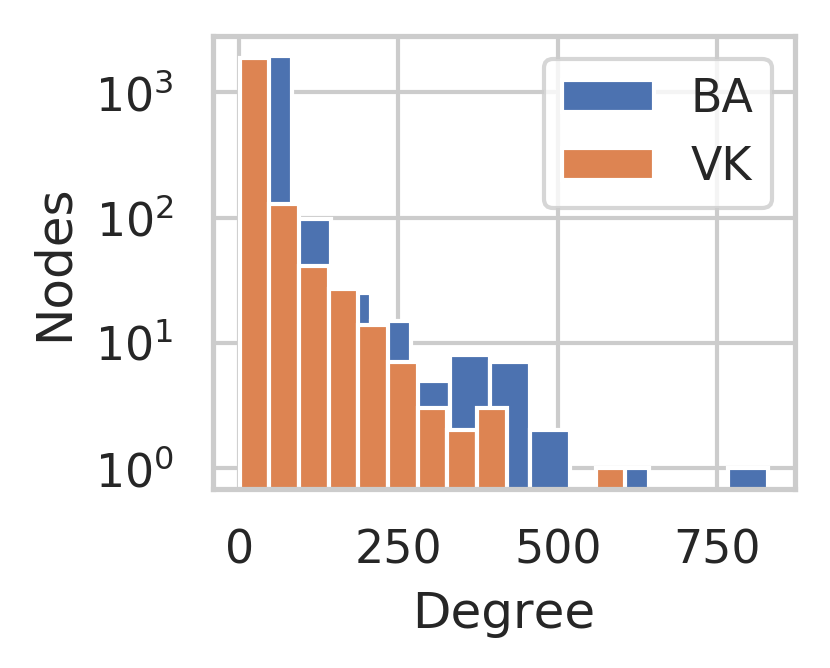

In [107]:
degrees1 = pd.Series([d for n, d in G2.degree()])
degrees2 = pd.Series([d for n, d in synG.degree()])
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,2)},style="whitegrid")
plt.yscale('log')
degrees2.hist(bins=13, label='BA')
degrees1.hist(bins=13, label='VK')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Nodes')

In [ ]:
# open graph, save in format
g = nx.convert_node_labels_to_integers(nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_real.pkl')))
nx.write_gpickle(g, os.path.join(config['general']['DataPath'], 'vk_graph_2_real_seq.pkl'))

g = nx.convert_node_labels_to_integers(nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_fake_p.pkl')))
nx.write_gpickle(g, os.path.join(config['general']['DataPath'], 'vk_graph_2_fake_p_seq.pkl'))

g = nx.convert_node_labels_to_integers(nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_fake.pkl')))
nx.write_gpickle(g, os.path.join(config['general']['DataPath'], 'vk_graph_power_fake_seq.pkl'))

g = nx.convert_node_labels_to_integers(nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_real.pkl')))
nx.write_gpickle(g, os.path.join(config['general']['DataPath'], 'vk_graph_power_real_seq.pkl'))

In [448]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_fake_seq.pkl'))
nx.write_edgelist(g, os.path.join(config['general']['DataPath'], 'ba_edgelist.csv'),data=False)

In [ ]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_real_seq.pkl'))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp', 'attribute.txt'),"w") as f:
    f.write('n={}\nm={}'.format(g.number_of_nodes(), g.number_of_edges()))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp', 'attributes.txt'),"w") as f:
    f.write('n={}\nm={}\ngraph_id=0'.format(g.number_of_nodes(), g.number_of_edges()))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp', 'graph_ic.inf'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
        
with open(os.path.join(config['general']['DataPath'], 'graph_tmp', 'graph.csv'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
        
        
        
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_fake_p_seq.pkl'))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp2', 'attribute.txt'),"w") as f:
    f.write('n={}\nm={}'.format(g.number_of_nodes(), g.number_of_edges()))
    
with open(os.path.join(config['general']['DataPath'], 'graph_tmp2', 'attributes.txt'),"w") as f:
    f.write('n={}\nm={}\ngraph_id=0'.format(g.number_of_nodes(), g.number_of_edges()))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp2', 'graph_ic.inf'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp2', 'graph.csv'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
        
        
        
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_fake_seq.pkl'))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp3', 'attribute.txt'),"w") as f:
    f.write('n={}\nm={}'.format(g.number_of_nodes(), g.number_of_edges()))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp3', 'attributes.txt'),"w") as f:
    f.write('n={}\nm={}\ngraph_id=0'.format(g.number_of_nodes(), g.number_of_edges()))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp3', 'graph_ic.inf'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp3', 'graph.csv'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
        
        
        
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_real_seq.pkl'))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp4', 'attribute.txt'),"w") as f:
    f.write('n={}\nm={}'.format(g.number_of_nodes(), g.number_of_edges()))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp4', 'attributes.txt'),"w") as f:
    f.write('n={}\nm={}\ngraph_id=0'.format(g.number_of_nodes(), g.number_of_edges()))

with open(os.path.join(config['general']['DataPath'], 'graph_tmp4', 'graph_ic.inf'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))
with open(os.path.join(config['general']['DataPath'], 'graph_tmp4', 'graph.csv'),"w") as f:
    for e in g.edges(data=True):
        f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

In [ ]:
# run IMM solver at this point, in IMM folder

In [109]:
seeds_for_vk_real = [1168, 1288, 497, 595, 219, 788, 548, 648, 1257, 297, 465, 1677, 960, 980, 1050, 1725, 1691, 558, 1414, 76, 560, 44, 1383, 469, 1656, 1370, 201, 1950, 941, 1110, 443, 374, 677, 849, 1452, 1372, 1102, 1064, 2052, 240, 1865, 337, 450, 707, 1308, 945, 1400, 1329, 126, 860, 1753, 96, 1808, 624, 209, 729, 1836, 1152, 1321, 1425, 1107, 1640, 1957, 1523, 1212, 1319, 470, 1015, 591, 1427, 419, 529, 1516, 192, 246, 1548, 169, 1281, 1522, 1480, 1720, 1816, 1298, 1756, 839, 1057, 1826, 1539, 574, 452, 1309, 1356, 664, 896, 755, 344, 78, 1101, 1220, 1399, 1181, 620, 1359, 974, 949, 1391, 1090, 2008, 82, 1915, 1486, 1464, 740, 753, 1511, 1665, 1727, 987, 920, 167, 766, 1232, 102, 1392, 799, 1010, 1734, 672, 363, 0, 1875, 1277, 428, 1342, 1494, 1323, 829, 488, 908, 639, 726, 1851, 217, 1610, 1767, 2093, 259, 813, 1233, 1799, 1385, 1180, 963, 247, 2009, 1275, 828, 1162, 436, 1413, 1577, 1311, 819, 1818, 1795, 1433, 1088, 1160, 357, 1918, 1770, 1896, 1574, 1449, 586, 743, 1883, 686, 717, 772, 385, 911, 1569, 833, 1079, 1336, 422, 1682, 977, 1255, 1646, 1238, 1791, 1273, 1004, 365, 834, 1147, 1962, 1924, 1167, 1588, 1038, 1738, 1328, 2067, 795, 2045, 654, 214, 1726, 972, 561, 449, 1806, 1782, 1673, 1700, 1335, 1961, 116, 1599, 1661, 1554, 1862, 1114, 1500, 1584, 1747, 1060, 400, 566, 338, 889, 615, 841, 867, 1586, 1568, 1859, 1885, 1668, 2088, 2075, 868, 1553, 1034, 1942, 1208, 389, 1938, 536, 662, 1459, 1260, 572, 1976, 1241, 336, 870, 1607, 1037, 725, 90, 592, 939, 1975, 552, 1880, 1526, 532, 1644, 670, 1089, 1742, 1185, 458, 1266, 874, 735, 1293, 1600, 1593, 360, 1254, 94, 148, 1785, 1565, 2056, 1401, 933, 641, 1345, 935, 872, 944, 1797, 1854, 764, 519, 1872, 1149, 1928, 1901, 1792, 863, 1672, 798, 1462, 1022, 1952, 2085, 1788, 503, 1596, 1935, 651, 1184, 1815, 2077, 1874, 1156, 319, 821, 1302, 393, 550, 1919, 1081, 720, 1572, 1438, 1597, 95, 1694, 1730, 1601, 698, 1955, 1228, 1368, 1737, 1250, 1856, 970, 1394, 2035, 1718, 782, 2080, 1021, 1422, 1426, 85, 7, 1731, 534, 241, 1562, 682, 1012, 1786, 988, 728, 1326, 1393, 1755, 1158, 2079, 2070, 1627, 1837, 1740, 1978, 2032, 1744, 1977, 2031, 223, 1981, 1443, 1355, 2026, 1606, 1643, 1230, 794, 1020, 1455, 878, 369, 1478, 1834, 2022, 471, 1118, 1051, 761, 1989, 1690, 801, 1814, 1932, 792, 1934, 1860, 1802, 1330, 1964, 1630, 1801, 83, 1829, 1925, 1415, 847, 760, 793, 805, 1121, 1297, 1018, 1042, 538, 1358, 2010, 125, 771, 1437, 476, 480, 1053, 1620, 787, 1679, 925, 671, 2060, 1906, 567, 2083, 1559, 1207, 1557, 704, 1639, 1312, 1775, 1920, 1774, 517, 1528, 940, 668, 1765, 979, 628, 1532, 1947, 1005, 1244, 1579, 2055, 1613, 1931, 2046, 1926, 1898, 2001, 932, 1969, 742, 272, 1993, 1992, 1908, 1822, 1823, 1365, 580, 1456, 293, 1609, 716, 1530, 1900, 781, 1897, 573, 27, 770, 943, 1541, 1276, 1222, 823, 1736, 864, 2019, 844, 2018, 1779, 1820, 1290, 1303, 727, 1258, 1773, 663, 101, 1366, 916, 1632, 1576, 1752, 676, 1907, 1623, 700, 985, 1465, 2090, 757, 1705, 780, 486, 1997, 721, 2087, 2027, 691, 1065, 1979, 1983, 2074, 2012, 1715, 1280, 1120, 1764, 1420, 1175, 1695, 2084, 1529, 1911, 2020, 1527, 593, 581, 1592, 1367, 493, 706, 1296, 1941, 1663, 1861, 1996, 212, 695, 1316, 1518, 1416, 953, 842, 806, 800, 1987, 722, 758, 260, 732, 1294, 2011, 2002, 1007, 1219, 724, 2061, 666, 1722, 783, 1960, 957, 2040, 1944, 2030, 1868, 1344, 1498, 1810, 1967, 1466, 1380, 1278, 1809, 229, 1895, 1379, 1439, 1923, 134, 733, 815, 1411, 1603, 224, 1769, 817, 376, 1538, 1675, 1762, 1812, 853, 1780, 1196, 1886, 2076, 2058, 1787, 667, 897, 711, 1295, 1035, 1696, 2004, 846, 1803, 1882, 791, 1402, 808, 1223, 1556, 1873, 423, 2082, 484, 1712, 1870, 1190, 1103, 1670, 741, 1719, 1732, 1647, 1645, 2068, 1628, 701, 688, 1778, 832, 1389, 1972, 2062, 1378, 2017, 2034, 1771, 1507, 1921, 1988, 2086, 1804, 1384, 1973, 881, 1549, 1654, 1575, 1084, 712, 2039, 1621, 1353, 432, 1729, 468, 546, 1504, 705, 1980, 1340, 1855, 1933, 1542, 859, 1614, 2024, 1524, 1819, 1396, 1023, 778, 1943, 1709, 1951, 54, 1585, 2059, 1322, 1116, 1547, 1263, 1436, 1320, 1362, 1339, 1259, 2041, 2016, 851, 339, 1899, 714, 1703, 1519, 1629, 563, 1029, 1910, 1995, 1578, 462, 843, 570, 1825, 2036, 1265, 2057, 302, 1268, 1292, 1968, 1477, 1746, 1683, 226, 1563, 1306, 1540, 1948, 539, 678, 1457, 1235, 2091, 1404, 2089, 1706, 1327, 1602, 1739, 2042, 1853, 1581, 1687, 1813, 1884, 1550, 2092, 1735, 1946, 906, 871, 445, 252, 929, 637, 1256, 1904, 1348, 1863, 1634, 1793, 549, 1913, 1638, 1949, 284, 1300, 258, 745, 225, 494, 1313, 1410, 2028, 1671, 1758, 2043, 1881, 1561, 1866, 1833, 1589, 1637, 1641, 1245, 647, 1127, 822, 1248, 926, 1491, 653, 1890, 1953, 79, 1684, 262, 1999, 533, 1172, 1347, 625, 2037, 1708, 1115, 1998, 1963, 751, 354, 1161, 1418, 1093, 1441, 189, 1798, 618, 719, 1200, 1831, 790, 786, 2003, 2025, 1888, 1475, 718, 232, 501, 1545, 1954, 1267, 803, 1406, 1636, 1195, 744, 366, 330, 1560, 1929, 1590, 1508, 1369, 1772, 345, 610, 922, 2033, 120, 147, 1986, 812, 660, 1994, 617, 435, 958, 692, 306, 1105, 2044, 1667, 2048, 2073, 1231, 709, 1193, 234, 930, 845, 802, 274, 965, 1483, 1033, 1213, 1717, 1871, 2005, 555, 629, 1041, 975, 482, 1097, 1226, 1506, 340, 1784, 1171, 1669, 838, 1087, 1697, 1497, 117, 2049, 1159, 679, 535, 255, 1716, 91, 835, 1113, 1811, 1026, 495, 936, 487, 1686, 1658, 840, 1179, 1710, 257, 1619, 2038, 1956, 489, 1315, 527, 1521, 1936, 433, 287, 1451, 875, 1350, 1525, 1648, 1763, 1835, 1008, 1496, 951, 1847, 1852, 1845, 1794, 1711, 1714, 168, 1555, 1832, 2015, 797, 111, 747, 923, 318, 748, 203, 2065, 2072, 394, 1982, 1301, 836, 1513, 1474, 1409, 1073, 1776, 825, 124, 2014, 1252, 2081, 1056, 1990, 1879, 1733, 301, 1659, 738, 2023, 396, 414, 1227, 934, 1761, 1843, 713, 1914, 634, 952, 1202, 898, 1841, 773, 2066, 907, 2064, 1922, 1221, 1750, 768, 1674, 1080, 1229, 1177, 2071, 1649]

In [110]:
seeds_for_vk_fake = [21, 107, 1452, 992, 1454, 1304, 404, 387, 163, 1427, 918, 316, 381, 1025, 1178, 314, 598, 512, 584, 1458, 638, 46, 118, 1305, 439, 1233, 540, 983, 1031, 201, 452, 358, 430, 509, 197, 762, 1651, 263, 1470, 106, 1144, 425, 1388, 1311, 913, 1418, 1119, 1382, 1566, 1431, 677, 616, 1720, 443, 1728, 139, 693, 1546, 457, 363, 582, 1234, 910, 1395, 1698, 1307, 1673, 1142, 1821, 311, 1537, 151, 1799, 167, 566, 1937, 1166, 786, 1428, 0, 1412, 934, 332, 604, 434, 1797, 100, 1628, 1894, 1849, 1052, 1219, 1726, 1375, 534, 1226, 1790, 1501, 1127, 399, 1113, 1420, 1047, 1976, 303, 562, 1026, 1115, 707, 1167, 852, 1727, 1108, 1203, 47, 344, 1610, 449, 51, 891, 1826, 813, 2008, 1391, 1594, 336, 1255, 529, 1387, 1755, 1896, 2018, 1753, 1676, 1734, 1038, 1155, 574, 1208, 1210, 778, 1103, 131, 156, 94, 1098, 129, 502, 422, 1966, 1886, 1494, 1053, 977, 1141, 112, 389, 1918, 1298, 1090, 573, 1569, 1791, 1848, 666, 1924, 1658, 1061, 1917, 1964, 1644, 1243, 647, 1046, 82, 561, 1293, 1730, 1890, 941, 7, 1614, 654, 1089, 1938, 1722, 972, 1801, 428, 1554, 382, 1795, 1081, 1876, 1885, 788, 524, 1524, 1672, 1697, 1212, 102, 2078, 333, 1165, 1368, 2051, 863, 897, 795, 1217, 1132, 1195, 1438, 2031, 991, 436, 1022, 1947, 1952, 759, 1855, 259, 1426, 1862, 1180, 1152, 1043, 2071, 87, 419, 1565, 1425, 1846, 1547, 1370, 1587, 1292, 2028, 1814, 1816, 1250, 1184, 1740, 1172, 1410, 1823, 641, 85, 1363, 907, 1596, 1742, 1318, 885, 1042, 1988, 1121, 1579, 1901, 2079, 458, 1433, 1747, 2053, 702, 1422, 1670, 1308, 148, 974, 1872, 1526, 374, 2060, 2075, 1467, 360, 1342, 1312, 1999, 1182, 488, 1528, 1456, 1414, 626, 1522, 670, 2077, 1393, 1962, 1975, 1738, 1223, 241, 1050, 355, 324, 719, 1505, 338, 538, 1401, 1679, 516, 1646, 1079, 1185, 1919, 1815, 1136, 1534, 2022, 1992, 2088, 1817, 1880, 1087, 550, 2080, 965, 135, 1744, 586, 1606, 1987, 1260, 1235, 1926, 1577, 1752, 1731, 1518, 1365, 1955, 2017, 44, 64, 634, 1572, 1599, 1808, 1700, 1015, 1303, 1443, 1021, 1718, 1326, 1626, 1934, 1763, 2085, 1725, 2035, 1853, 1396, 560, 651, 2020, 1756, 1589, 1549, 1765, 147, 1323, 1792, 526, 988, 2005, 878, 1898, 1841, 70, 1473, 1897, 1777, 1983, 1831, 2036, 1257, 1162, 1907, 1423, 1630, 1925, 792, 1928, 1556, 869, 1682, 1914, 1597, 272, 1785, 1810, 168, 688, 1309, 1669, 1276, 1190, 2045, 1206, 2056, 1856, 1532, 423, 2012, 1394, 1297, 1478, 581, 2000, 849, 552, 2013, 274, 1585, 563, 532, 2069, 1441, 872, 1678, 963, 2007, 2001, 78, 1012, 2067, 1159, 732, 1611, 154, 2046, 1837, 1574, 480, 1316, 1024, 1404, 1345, 2055, 1207, 1946, 401, 1804, 1900, 1835, 2019, 27, 1978, 306, 1358, 1910, 1164, 610, 1419, 134, 1788, 760, 1942, 800, 1459, 1623, 1879, 721, 1659, 1378, 1529, 624, 908, 1932, 432, 867, 2086, 1968, 1592, 1591, 2061, 985, 722, 1603, 1157, 1882, 1813, 1624, 2084, 1377, 874, 1588, 1981, 1449, 1609, 943, 1661, 1066, 770, 1870, 1176, 418, 1328, 1204, 1033, 605, 517, 1399, 1936, 1834, 1969, 806, 2058, 1415, 1767, 1860, 2030, 1762, 1643, 1850, 819, 1923, 1593, 1265, 2027, 787, 1005, 130, 1967, 111, 377, 1091, 1820, 944, 1771, 653, 54, 1120, 396, 1844, 192, 1381, 1302, 1254, 1389, 567, 663, 1241, 1899, 1710, 1464, 764, 1857, 1125, 1355, 1973, 1854, 1411, 2090, 682, 1197, 951, 1520, 1324, 1840, 1824, 1861, 1604, 1550, 975, 1957, 2037, 1568, 1256, 2026, 101, 372, 2032, 1732, 724, 780, 1902, 2065, 1149, 503, 1107, 1781, 120, 1868, 1933, 1466, 2062, 1367, 898, 1993, 1865, 1632, 1671, 2034, 1486, 1104, 911, 1513, 1498, 238, 640, 1739, 593, 1601, 1462, 1994, 2083, 1859, 2004, 1985, 1056, 1959, 843, 1663, 1712, 1491, 1930, 2072, 345, 1527, 1929, 1131, 1915, 1852, 1749, 1105, 1193, 1931, 1434, 706, 1295, 125, 755, 979, 1088, 817, 1863, 198, 505, 535, 76, 1619, 1845, 340, 1906, 1356, 1548, 1392, 235, 1908, 888, 414, 619, 970, 537, 1827, 781, 1717, 1787, 1621, 1564, 2057, 1330, 1789, 2050, 728, 1280, 1883, 2039, 2002, 1602, 1517, 2033, 1704, 900, 1029, 906, 1709, 287, 1435, 1354, 533, 1660, 1736, 1542, 2024, 2066, 1541, 1030, 1954, 1380, 1084, 1782, 310, 1875, 383, 1336, 1530, 997, 592, 932, 1654, 1825, 570, 635, 1362, 1145, 1798, 116, 1690, 1769, 805, 2006, 1822, 1060, 1758, 2092, 1465, 1239, 953, 2010, 339, 1237, 1488, 174, 1437, 1344, 1451, 1562, 1416, 2025, 1666, 1694, 95, 1656, 1851, 1920, 378, 2049, 1497, 1306, 1480, 1650, 1192, 1913, 844, 2093, 284, 1070, 981, 1576, 1977, 1764, 1941, 870, 1735, 1802, 1995, 745, 1921, 1881, 369, 1506, 1485, 2043, 1944, 1613, 1357, 748, 1949, 108, 637, 93, 1581, 252, 942, 1080, 2082, 1294, 1507, 2070, 1888, 735, 2091, 1986, 1629, 798, 1943, 1711, 1958, 982, 1828, 96, 1864, 1695, 1398, 398, 621, 1990, 1836, 1873, 232, 1634, 327, 1972, 639, 1590, 1796, 1245, 166, 1716, 846, 1289, 2074, 1310, 1684, 969, 346, 482, 435, 615, 899, 1586, 1082, 935, 1963, 1724, 1567, 1188, 2015, 1116, 1989, 1800, 152, 2029, 1686, 1723, 1545, 1895, 539, 486, 1039, 1637, 1866, 1177, 1707, 698, 2068, 704, 50, 1372, 1385, 271, 226, 1075, 625, 1858, 714, 1539, 2059, 5, 1770, 1699, 229, 1094, 2063, 679, 1960, 1222, 385, 2016, 1991, 1552, 1049, 860, 2038, 528, 1376, 1525, 1668, 2044, 1266, 1018, 1340, 1633, 445, 1369, 1457, 686, 1830, 1600, 1315, 1246, 2040, 1563, 1794, 1321, 1543, 1516, 1299, 1812, 128, 1483, 1439, 1703, 1515, 1803, 771, 1508, 1320, 1702, 304, 1760, 1953, 1097, 1258, 1648, 1335, 536, 790, 1134, 1361, 1951, 1687, 1479, 1062, 1759, 1417, 1402, 1301, 1313, 884, 841, 1544, 4, 554, 1950, 618, 1557, 853, 1499, 1780, 1582, 1754, 1041, 709, 2014, 847, 1409, 757, 1627, 1956, 501, 1366, 1693, 1032, 1158, 1961, 656, 662, 957, 1007, 2042, 632, 585, 1231, 1290, 2089, 1273, 751, 1778, 1140, 519, 1839, 1198, 987, 1432, 1296, 1474, 1242, 185, 1037, 862, 1733, 1484, 1291, 1511, 455, 2064, 1818, 1126, 1927, 1000, 1023, 1278, 622, 1998, 176, 1750, 2073, 1413, 522, 958, 807, 290, 1475, 808, 802, 1350, 1156, 1154, 1521, 1833, 1343, 1504, 1481, 1911, 1786]

In [112]:
seeds_for_ba_fake = [11, 1081, 948, 784, 1670, 804, 1456, 1605, 1257, 455, 233, 1619, 416, 2042, 1596, 1491, 1738, 613, 683, 2004, 920, 1872, 1335, 1088, 1207, 1401, 1045, 1043, 1962, 1051, 1545, 877, 1875, 1911, 1105, 1939, 1387, 1422, 2087, 1450, 1291, 1200, 608, 1367, 1123, 1976, 1506, 1835, 1172, 1256, 1614, 651, 1557, 1815, 1783, 757, 2068, 1974, 1730, 814, 1318, 1866, 1293, 1922, 1403, 2029, 1915, 1752, 1356, 982, 1917, 555, 1853, 1855, 1205, 2061, 1697, 1312, 940, 1929, 1750, 2024, 1858, 1339, 870, 1260, 2045, 1532, 2078, 1921, 1737, 1410, 1175, 1846, 1299, 1455, 1746, 1890, 1405, 1932, 567, 2080, 1549, 1201, 1723, 720, 1861, 1086, 1944, 1537, 1254, 1979, 1522, 1708, 1135, 1520, 1357, 682, 1240, 1033, 1645, 1742, 1602, 1484, 564, 1770, 1740, 308, 1862, 798, 1281, 1918, 2064, 1391, 1494, 1572, 1336, 1434, 898, 1729, 1792, 901, 1378, 1377, 1831, 1451, 1851, 1552, 1307, 1744, 715, 1963, 2021, 1969, 1942, 1690, 775, 1678, 1153, 524, 1526, 868, 1661, 1894, 1871, 1271, 1799, 1755, 1606, 1565, 964, 1529, 562, 1901, 1464, 1490, 622, 1817, 1463, 1641, 1978, 1454, 1589, 1326, 1885, 1173, 1199, 1821, 1539, 1840, 2069, 1801, 1924, 2041, 1995, 1829, 796, 1394, 1786, 1930, 876, 1910, 681, 1511, 832, 1392, 1412, 767, 1185, 1141, 1705, 1814, 1231, 1342, 2075, 1268, 793, 1776, 1385, 1952, 1276, 2050, 1244, 1757, 1296, 2001, 1823, 1629, 1856, 1365, 1543, 1498, 1562, 2051, 2076, 1443, 1469, 1712, 1210, 1008, 1696, 1676, 1935, 2067, 714, 1360, 277, 701, 1556, 1047, 1258, 1893, 1140, 568, 1152, 1233, 1568, 1020, 2077, 1414, 1226, 1127, 2055, 815, 1826, 1261, 1880, 958, 1973, 1876, 1984, 2039, 1671, 1795, 1658, 1168, 1800, 1625, 1673, 1019, 844, 1788, 1843, 1886, 1656, 1431, 1991, 1718, 1727, 795, 716, 2025, 2047, 724, 1927, 1700, 2016, 1237, 1713, 1049, 2088, 1764, 377, 1290, 1971, 1106, 1959, 2026, 1082, 1310, 1775, 1048, 1896, 1756, 1816, 1852, 1841, 1305, 1148, 1438, 1137, 1892, 1570, 1688, 2060, 626, 1773, 1772, 1968, 1702, 783, 1252, 1462, 1640, 1079, 604, 1503, 1653, 1768, 2017, 1220, 1747, 1426, 1470, 1754, 1989, 1622, 1936, 953, 1179, 1587, 1845, 1966, 1581, 566, 1811, 1735, 1651, 1497, 840, 1724, 1002, 1566, 1459, 1623, 1171, 1675, 1854, 1748, 1937, 1567, 1354, 1859, 1874, 1145, 685, 1576, 1660, 1988, 1947, 1715, 1433, 1620, 1474, 1149, 243, 1990, 1302, 1789, 1916, 703, 1946, 2038, 1303, 2083, 1895, 476, 1731, 1471, 1542, 862, 1599, 869, 1449, 1907, 894, 1524, 607, 1025, 1760, 954, 1850, 1441, 1679, 763, 1632, 1938, 776, 1900, 1588, 974, 1637, 1761, 2090, 1109, 1309, 1633, 1509, 2044, 2063, 2085, 1311, 1933, 1259, 1269, 1630, 1624, 1741, 1934, 662, 1600, 478, 158, 1466, 1787, 1769, 1530, 1040, 1393, 2086, 944, 2057, 1053, 1118, 735, 1440, 1820, 349, 1018, 989, 1119, 1972, 2007, 1219, 1657, 1447, 1429, 1013, 1781, 1428, 1970, 1643, 1834, 1371, 1534, 1044, 414, 1009, 1926, 933, 1267, 1330, 1618, 1593, 1363, 1960, 907, 1879, 1993, 1316, 1612, 517, 1381, 1227, 2072, 1286, 2028, 1983, 1439, 1084, 1998, 688, 1069, 1021, 1664, 1668, 1689, 1235, 446, 1849, 1884, 1897, 534, 690, 1839, 1525, 1677, 1650, 1476, 628, 1017, 1514, 1569, 863, 538, 1919, 1273, 1159, 1535, 1156, 1353, 1691, 1246, 1164, 1208, 760, 1819, 509, 1113, 1546, 2035, 1395, 1560, 1536, 317, 1780, 415, 1274, 1981, 1325, 1771, 543, 1734, 1611, 1304, 1888, 1920, 1275, 1400, 1778, 1751, 1337, 1836, 693, 2059, 1328, 1315, 1686, 1726, 1717, 1564, 1797, 1461, 1413, 1241, 1150, 1908, 1994, 2037, 963, 1663, 413, 1355, 1578, 2005, 860, 600, 794, 1863, 1327, 1031, 1883, 1453, 1332, 1117, 1719, 2092, 634, 573, 966, 702, 1694, 2012, 1333, 282, 1940, 1617, 2003, 1652, 1716, 1881, 1837, 1684, 1591, 1613, 831, 1467, 1639, 1822, 1553, 1170, 409, 2071, 381, 620, 1642, 1211, 471, 732, 667, 1655, 1308, 2081, 1500, 1386, 1249, 1923, 1867, 2030, 1693, 859, 2020, 1406, 2089, 1659, 2062, 2065, 1094, 1864, 921, 2023, 1099, 1218, 1359, 1158, 1147, 1865, 1870, 503, 1475, 1487, 1759, 574, 670, 1725, 880, 1504, 1282, 2031, 2082, 1162, 1913, 1507, 833, 1848, 1669, 1706, 842, 1928, 700, 1334, 531, 2019, 1499, 827, 527, 905, 1798, 1987, 368, 1548, 1280, 2036, 1245, 856, 508, 1436, 1733, 2013, 766, 1083, 2006, 1665, 761, 1603, 699, 1575, 1925, 1121, 919, 1791, 1022, 1860, 2074, 1949, 1766, 1225, 1687, 1427, 1341, 1701, 1369, 1681, 1416, 1248, 1732, 1279, 1368, 1873, 1184, 918, 1762, 1887, 1419, 315, 1050, 1151, 1074, 2093, 250, 599, 985, 2056, 1903, 1239, 1824, 1479, 1516, 1382, 1214, 1828, 1803, 1547, 1878, 63, 1941, 1703, 2091, 1209, 154, 1790, 1177, 1698, 189, 1448, 1306, 891, 854, 1621, 346, 774, 1091, 1666, 1114, 1580, 2000, 554, 1338, 1408, 1396, 1985, 1186, 2032, 986, 1555, 319, 1038, 1709, 1373, 1468, 1957, 1833, 411, 2066, 945, 1945, 593, 2058, 1844, 1407, 504, 1344, 1999, 1550, 2010, 1136, 1644, 1229, 1796, 825, 764, 1176, 638, 2073, 1277, 1242, 2046, 867, 1066, 887, 1144, 1627, 930, 1424, 1206, 1055, 1812, 1278, 1217, 830, 1586, 1178, 1728, 1604, 605, 769, 1213, 1089, 1518, 975, 522, 1982, 977, 1753, 1877, 1161, 2079, 1289, 758, 976, 1531, 344, 1146, 1517, 1501, 1523, 762, 1230, 1810, 1882, 1592, 1818, 1358, 565, 1107, 1234, 1722, 1411, 1349, 1554, 1986, 1646, 789, 1594, 1912, 925, 1195, 1032, 947, 834, 890, 2002, 889, 191, 609, 1098, 572, 910, 1104, 1183, 2040, 1680, 665, 1163, 1868, 1582, 1538, 2054, 1272, 1782, 1380, 222, 1204, 659, 2022, 1647, 826, 1374, 1460, 1904, 1626, 1483, 1478, 929, 731, 1527, 1767, 312, 1182, 606, 2018, 1250, 2027, 1808, 1763, 2049, 1958, 722, 756, 697, 1902, 1212, 1711, 820, 505, 983, 935, 879, 1115, 1793, 1889, 1247, 1345, 924, 1739, 2014, 1486, 1383, 1270, 978, 122, 2008, 1758, 1076, 990, 1323, 1238, 1992, 1601, 249, 1343, 1376, 719, 1898, 1598, 857, 1743, 441, 1975, 1361, 1595, 1075, 969, 1418, 592, 1551, 734, 1181, 1707, 596, 1370, 1493, 727, 1480, 707, 946, 972, 1297, 382, 1597, 286, 1774, 1607, 993, 1765, 1610, 625, 2070, 1899, 1351, 824, 710, 1236, 1847, 1202, 337, 1721, 1110, 745, 603, 1265, 247, 678, 988, 1654, 1951, 500, 956, 1685, 666, 677, 1830, 1906, 376]

In [113]:
seeds_for_ba_real = [967, 1614, 2071, 1638, 1768, 1618, 1993, 1546, 1391, 2075, 863, 1947, 1437, 2067, 1752, 1172, 1834, 1885, 1812, 1025, 2039, 1510, 1201, 1334, 1265, 1755, 1846, 1150, 2035, 1123, 2030, 1910, 881, 1458, 1309, 1719, 1463, 1217, 1765, 950, 2070, 1906, 1283, 930, 2061, 1048, 1917, 1625, 1091, 1762, 1518, 2026, 1980, 1928, 1706, 1911, 1967, 1567, 1964, 1690, 1860, 1467, 1261, 1804, 1449, 1634, 2019, 1643, 1553, 1841, 1784, 1229, 1640, 1376, 1903, 1821, 1215, 917, 1783, 792, 1379, 1396, 1354, 1579, 966, 1829, 1108, 1990, 1868, 2001, 1853, 891, 1852, 1702, 862, 933, 951, 1862, 977, 1017, 2011, 1741, 1385, 2000, 1725, 1611, 1277, 1742, 1679, 1159, 2082, 1962, 1209, 1164, 1749, 1533, 1371, 1511, 1747, 1535, 1718, 1058, 1380, 1824, 1622, 1758, 2054, 755, 1880, 607, 748, 1438, 1641, 1356, 824, 1680, 850, 1780, 1106, 1431, 796, 1460, 1650, 1107, 1234, 1724, 1034, 1230, 1977, 1902, 1802, 1748, 1268, 2079, 1924, 1301, 1479, 829, 1183, 1639, 1276, 1254, 1031, 2009, 996, 2053, 1275, 1344, 1630, 1569, 442, 2031, 2037, 1595, 1905, 1452, 1207, 639, 2029, 1020, 1470, 1705, 1473, 1508, 1683, 1934, 1807, 1797, 1909, 1589, 1459, 1018, 509, 1606, 1513, 1601, 1968, 1766, 1052, 1740, 1843, 1874, 1325, 1865, 1720, 1472, 1987, 1407, 2032, 1635, 1950, 1387, 1628, 2028, 1526, 1818, 849, 1627, 1098, 1782, 1887, 1156, 1422, 1970, 1435, 1959, 1353, 1986, 1756, 732, 1764, 1792, 1305, 535, 1872, 1497, 1918, 1299, 1436, 1515, 886, 1110, 815, 710, 1240, 220, 1319, 1948, 1310, 1365, 1805, 1430, 1189, 1536, 1864, 1620, 1303, 1832, 674, 1642, 566, 1256, 2012, 1746, 2015, 1562, 1062, 1907, 1195, 340, 1901, 503, 1097, 1979, 1038, 1923, 1561, 1076, 1523, 699, 1219, 1441, 979, 2036, 1939, 1179, 880, 574, 2048, 1867, 1594, 1774, 1973, 1655, 1308, 726, 2083, 596, 734, 1785, 253, 1809, 1083, 1480, 1527, 1798, 2024, 1273, 1773, 568, 1653, 1778, 1695, 1775, 1711, 1897, 1406, 1908, 1416, 1587, 1972, 1883, 2091, 1930, 1976, 1991, 469, 1339, 1701, 1677, 1178, 1015, 1194, 1547, 1881, 1898, 1426, 1602, 1357, 1651, 1717, 1433, 1732, 2078, 1378, 1716, 1900, 1111, 1751, 921, 1826, 1556, 1942, 1549, 1833, 1759, 604, 1984, 1317, 1099, 756, 1366, 2042, 1096, 1300, 1351, 1925, 1844, 693, 837, 1644, 2017, 924, 1827, 964, 1599, 789, 711, 1554, 681, 831, 1787, 1153, 963, 1739, 2058, 1208, 1049, 758, 1393, 1412, 1709, 1423, 2090, 1568, 1530, 1810, 1592, 1158, 1946, 413, 1882, 1104, 603, 1682, 1723, 1566, 869, 249, 1678, 1983, 190, 991, 1543, 845, 1222, 1411, 1055, 667, 534, 2027, 1999, 1737, 1166, 1713, 1806, 1085, 1476, 1514, 1021, 1174, 669, 1646, 1190, 1745, 1578, 939, 1469, 1077, 1978, 1368, 928, 1286, 1241, 1214, 1615, 381, 1192, 1726, 1656, 1610, 2013, 1727, 2025, 1311, 774, 1255, 406, 188, 538, 1572, 2005, 543, 1848, 702, 764, 728, 1616, 1386, 1693, 1585, 1612, 1532, 1417, 1772, 1135, 2076, 1481, 1893, 1117, 1660, 1927, 2045, 1575, 2002, 1389, 1548, 1146, 1137, 1786, 1537, 1658, 731, 1699, 1404, 1118, 482, 1105, 1295, 1941, 1813, 1661, 1047, 1971, 769, 525, 1715, 456, 1896, 1369, 858, 976, 907, 1484, 1700, 905, 1101, 1963, 910, 510, 2074, 1671, 1517, 1494, 959, 561, 1895, 1087, 1668, 1621, 1989, 973, 1815, 1398, 1475, 918, 2088, 1795, 1359, 1213, 474, 1624, 1248, 956, 1539, 2003, 1933, 1335, 1373, 767, 638, 2043, 1845, 571, 1119, 1992, 1859, 1849, 1944, 1540, 1560, 1429, 622, 1760, 1307, 1851, 1490, 1788, 953, 312, 1839, 730, 522, 1721, 919, 1395, 1520, 1637, 1291, 1850, 1364, 1714, 2007, 1796, 1502, 1079, 1801, 1598, 1080, 1652, 1565, 1735, 1509, 2023, 1046, 1823, 884, 1545, 1789, 1171, 1731, 1272, 1503, 351, 1010, 318, 1738, 1684, 1134, 1500, 1136, 1955, 1116, 1377, 1486, 1237, 1904, 1712, 1888, 1388, 1835, 1028, 632, 1405, 1858, 2034, 1956, 2062, 1866, 1847, 989, 1035, 1464, 1744, 1495, 1529, 1112, 1871, 1333, 1538, 1167, 1235, 984, 1176, 2041, 1206, 889, 1355, 1293, 1081, 1600, 1027, 1794, 1448, 867, 654, 1274, 572, 1331, 1278, 1053, 1516, 1204, 1403, 1394, 1141, 342, 742, 1597, 1733, 278, 1588, 1445, 826, 1689, 1878, 1401, 1837, 1084, 684, 974, 1346, 1697, 1799, 1157, 1142, 1938, 688, 1825, 2065, 760, 1998, 540, 949, 794, 1729, 1232, 803, 2072, 2069, 602, 1512, 922, 838, 350, 1287, 892, 1686, 1593, 2004, 985, 1345, 1770, 1750, 1488, 2085, 1165, 542, 316, 379, 825, 2050, 1708, 1673, 888, 1282, 1584, 1707, 1186, 1603, 945, 1915, 2057, 2060, 1664, 1670, 157, 2044, 1259, 1478, 691, 2049, 1492, 1188, 1375, 1397, 791, 1899, 1771, 382, 532, 1392, 1544, 626, 1994, 955, 1330, 1564, 1665, 1151, 1315, 925, 1145, 1975, 1873, 1471, 1981, 1757, 1061, 2040, 1271, 2089, 940, 1360, 1011, 793, 890, 1687, 1692, 1586, 923, 1040, 763, 575, 2064, 1427, 2080, 1402, 1836, 2066, 1474, 1761, 599, 1688, 859, 1428, 947, 768, 1912, 1009, 2052, 1790, 1082, 2016, 1559, 1231, 2006, 1822, 1573, 1270, 1056, 1633, 1884, 1576, 1580, 916, 1042, 1879, 821, 1138, 844, 895, 1501, 31, 1250, 987, 914, 761, 1808, 123, 1960, 995, 635, 1102, 1617, 885, 1382, 1006, 1103, 1663, 1332, 1252, 1196, 580, 972, 1455, 766, 252, 2093, 375, 954, 1596, 1704, 567, 1943, 1875, 478, 1541, 1327, 1320, 2059, 1534, 1095, 1450, 1819, 915, 1935, 1647, 757, 1607, 1323, 2014, 759, 1439, 1645, 1363, 1949, 348, 1609, 1288, 1253, 1997, 1613, 637, 1114, 369, 1814, 1066, 1418, 1002, 1115, 1342, 1674, 1078, 1051, 1691, 1574, 1754, 504, 988, 1953, 314, 697, 1163, 1767, 1290, 1341, 1014, 1920, 1063, 690, 1932, 1023, 665, 408, 724, 1840, 1892, 2055, 1314, 2056, 714, 1776, 983, 957, 677, 990, 1869, 814, 1791, 463, 1191, 414, 63, 2068, 2038, 1506, 874, 634, 1629, 856, 1239, 1130, 1552, 1162, 736, 1838, 1498, 1489, 876, 1982, 275, 2063, 965, 1147, 1861, 1581, 1857, 901, 1820, 1487, 943, 1604, 799, 1211, 1413, 1143, 1221, 243, 1951, 1086, 948, 1817, 663, 1854, 700, 1485, 1499, 1831, 920, 1200, 1149, 1336, 1855, 1966, 1224, 349, 2087, 1965, 1551, 1961, 1205, 952, 415, 1161, 735, 1127, 1326, 883, 282, 1075, 1623, 1421, 1522, 1504, 798, 1370, 1919, 788, 813, 1109, 1779, 1769, 1367, 468, 1348, 1372, 1465, 1483, 1258, 1182, 573, 601, 536]

In [129]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_real_seq.pkl'))
degrees = [(node, g.degree([node])[node]) for node in g.nodes()]
degrees.sort(key=lambda t: t[1], reverse=True)
seeds_for_ba_degree = [s[0] for s in degrees[:len(seeds_for_ba_fake)]]

g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_real_seq.pkl'))
degrees = [(node, g.degree([node])[node]) for node in g.nodes()]
degrees.sort(key=lambda t: t[1], reverse=True)
seeds_for_vk_degree = [s[0] for s in degrees[:len(seeds_for_ba_fake)]]

In [200]:
import subprocess

seeds = [seeds_for_vk_real, seeds_for_vk_degree]
graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp')
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_result = []
for i in range(2):
    r = []
    seeds_now = seeds[i]
    for k_d in tqdm(range(3, 11)):
        k = 2**k_d
        with open(seed_path,"w") as f:
            for s in seeds_now[:k]:
                f.write('{}\n'.format(s))

        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append((k, result))
    all_result.append(np.array(r))
    
seeds = [seeds_for_vk_fake, seeds_for_vk_degree]
graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp2')
all_result2 = []
for i in range(2):
    r = []
    seeds_now = seeds[i]
    for k_d in tqdm(range(3, 11)):
        k = 2**k_d
        with open(seed_path,"w") as f:
            for s in seeds_now[:k]:
                f.write('{}\n'.format(s))

        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append((k, result))
    all_result2.append(np.array(r))

100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


In [426]:
clrs = sns.color_palette()

Text(0, 0.5, 'Active Nodes')

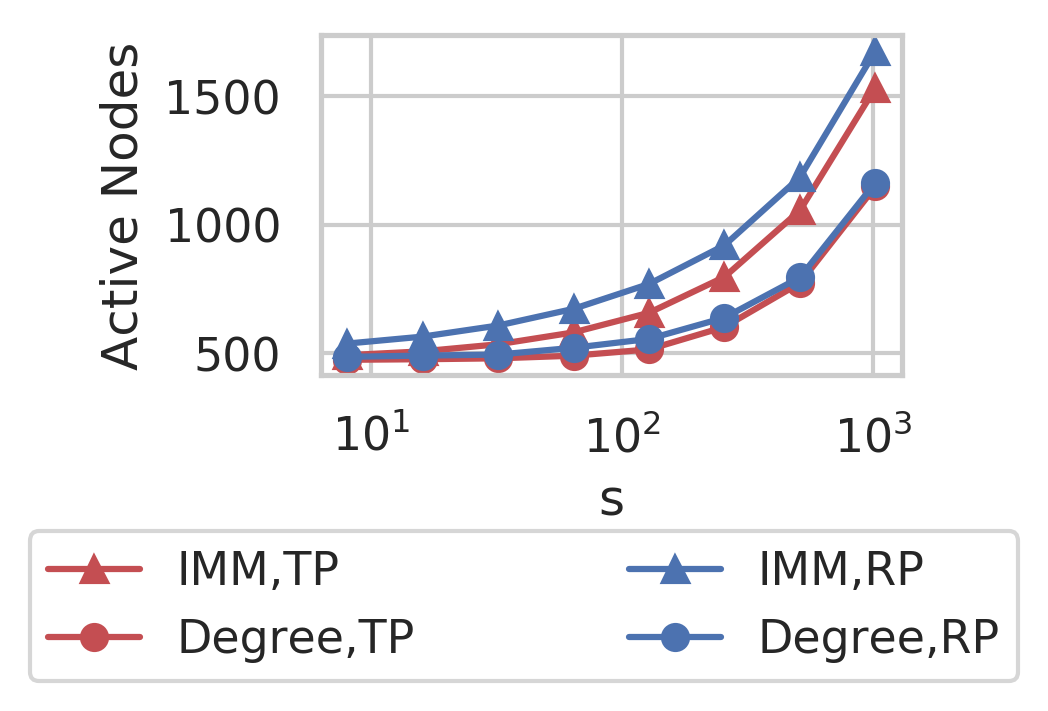

In [425]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_result2[0][:,0], all_result2[0][:,1], label="IMM,TP",marker='^', color=clrs[3])
plt.semilogx(all_result2[1][:,0], all_result2[1][:,1], label="Degree,TP",marker='o', color=clrs[3])

plt.semilogx(all_result[0][:,0], all_result[0][:,1], label="IMM,RP",marker='^', color=clrs[0])
plt.semilogx(all_result[1][:,0], all_result[1][:,1], label="Degree,RP",marker='o', color=clrs[0])

plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("s")
plt.ylabel("Active Nodes")

In [204]:
import subprocess

seeds = [seeds_for_ba_fake, seeds_for_ba_degree]
graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp3')
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_result3 = []
for i in range(2):
    r = []
    seeds_now = seeds[i]
    for k_d in tqdm(range(3, 11)):
        k = 2**k_d
        with open(seed_path,"w") as f:
            for s in seeds_now[:k]:
                f.write('{}\n'.format(s))

        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append((k, result))
    all_result3.append(np.array(r))

100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


In [205]:
import subprocess

seeds = [seeds_for_ba_real, seeds_for_ba_degree]
graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp4')
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_result4 = []
for i in range(2):
    r = []
    seeds_now = seeds[i]
    for k_d in tqdm(range(3, 11)):
        k = 2**k_d
        with open(seed_path,"w") as f:
            for s in seeds_now[:k]:
                f.write('{}\n'.format(s))

        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append((k, result))
    all_result4.append(np.array(r))

100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Text(0, 0.5, '$\\Delta_{\\mathit{rel}}$')

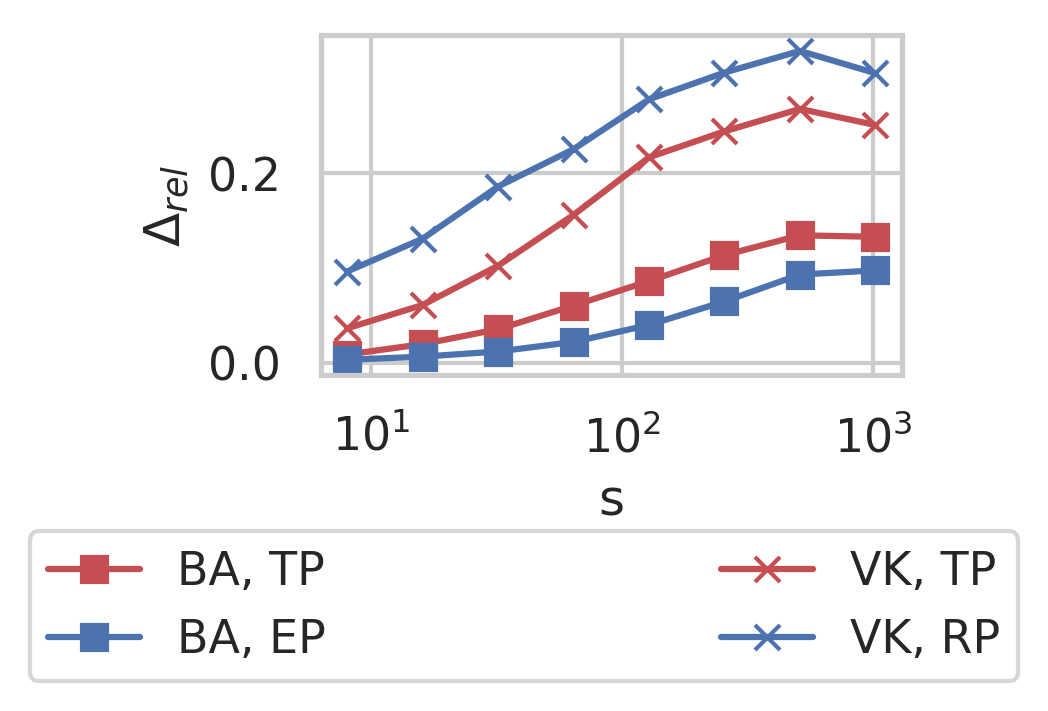

In [433]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_result3[0][:,0], (-all_result3[1][:,1]+all_result3[0][:,1])/all_result3[0][:,1], label="BA, TP",marker='s', color=clrs[3])
# plt.semilogx(all_result[1][:,0], all_result[1][:,1], label="Degree",marker='o')

plt.semilogx(all_result4[0][:,0], (-all_result4[1][:,1]+all_result4[0][:,1])/all_result4[0][:,1], label="BA, EP",marker='s', color=clrs[0])
# plt.semilogx(all_result2[1][:,0], all_result2[1][:,1], label="Degree R",marker='o')


plt.semilogx(all_result2[0][:,0], (-all_result2[1][:,1]+all_result2[0][:,1])/all_result2[0][:,1], label="VK, TP",marker='x', color=clrs[3])
plt.semilogx(all_result[0][:,0], (-all_result[1][:,1]+all_result[0][:,1])/all_result[0][:,1], label="VK, RP",marker='x', color=clrs[0])
# plt.semilogx(all_result[1][:,0], all_result[1][:,1], label="Degree",marker='o')


plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("s")
plt.ylabel("$\Delta_{\mathit{rel}}$")

Text(0, 0.5, 'Active Nodes')

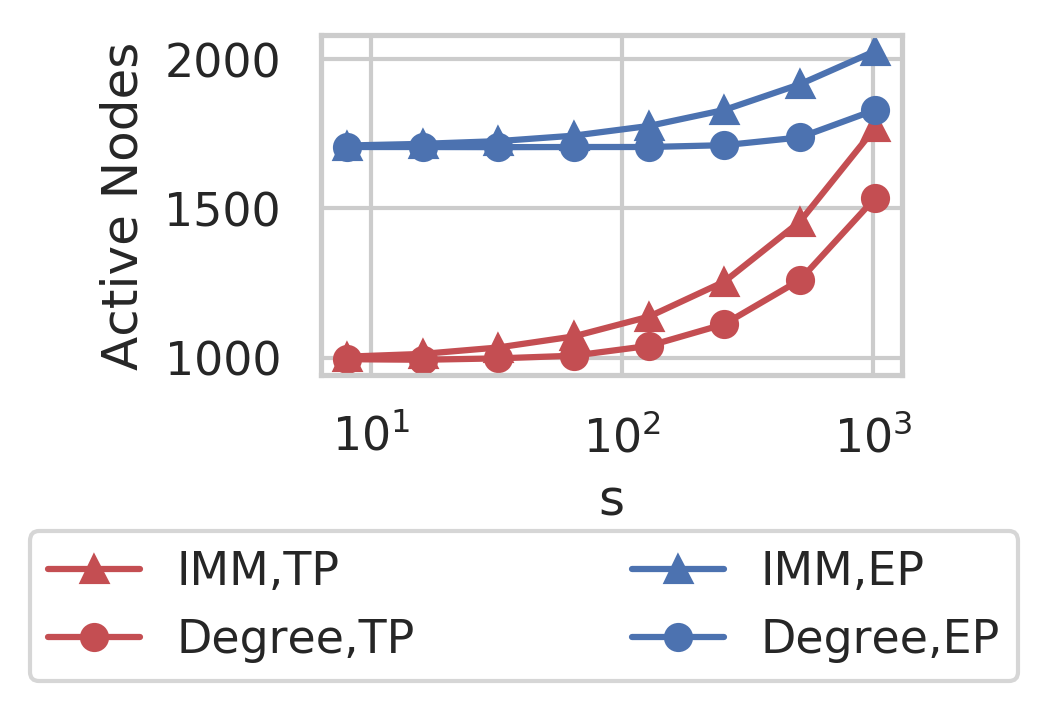

In [434]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_result3[0][:,0], all_result3[0][:,1], label="IMM,TP",marker='^', color=clrs[3])
plt.semilogx(all_result3[1][:,0], all_result3[1][:,1], label="Degree,TP",marker='o', color=clrs[3])

plt.semilogx(all_result4[0][:,0], all_result4[0][:,1], label="IMM,EP",marker='^', color=clrs[0])
plt.semilogx(all_result4[1][:,0], all_result4[1][:,1], label="Degree,EP",marker='o', color=clrs[0])
plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("s")
plt.ylabel("Active Nodes")

In [261]:
sys.path.append(os.path.join(os.environ['PHD_ROOT'], 'robust','src'))
from NetShieldSolver import *
from DomSolver import *

In [274]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_real_seq.pkl'))
seeds = seeds_for_vk_real[:100]
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_results = []
for k in tqdm([32, 64, 128, 256, 512, 1024]):
    netshield = NetShieldSolver(g,k=k,seeds=seeds)
    domsolver = DomSolver(g,k=k,seeds=seeds)
    netshield.run()
    domsolver.run()
    
    r = [k]
    for blocked_nodes in [domsolver.log['Blocked nodes'], netshield.log['Blocked nodes']]:
        g1 = g.copy()
        g1.remove_nodes_from(blocked_nodes)
        g1 = nx.convert_node_labels_to_integers(g1)
        a = dict([(n, True) for n in seeds])
        nx.set_node_attributes(g1, a, 'seed')
        with open(seed_path,"w") as f:
            for n in g1.nodes(data=True):
                if 'seed' in n[1]:
                    f.write('{}\n'.format(n[0]))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'attributes.txt'),"w") as f:
            f.write('n={}\nm={}\ngraph_id=0'.format(g1.number_of_nodes(), g1.number_of_edges()))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'graph.csv'),"w") as f:
            for e in g1.edges(data=True):
                f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

        graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp5')
        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append(result)
    all_results.append(r)
all_results = np.array(all_results)

100%|██████████| 6/6 [01:29<00:00, 18.12s/it]


In [277]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_2_fake_p_seq.pkl'))
seeds = seeds_for_vk_fake[:100]
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_results2 = []
for k in tqdm([32, 64, 128, 256, 512, 1024]):
    netshield = NetShieldSolver(g,k=k,seeds=seeds)
    domsolver = DomSolver(g,k=k,seeds=seeds)
    netshield.run()
    domsolver.run()
    
    r = [k]
    for blocked_nodes in [domsolver.log['Blocked nodes'], netshield.log['Blocked nodes']]:
        g1 = g.copy()
        g1.remove_nodes_from(blocked_nodes)
        g1 = nx.convert_node_labels_to_integers(g1)
        a = dict([(n, True) for n in seeds])
        nx.set_node_attributes(g1, a, 'seed')
        with open(seed_path,"w") as f:
            for n in g1.nodes(data=True):
                if 'seed' in n[1]:
                    f.write('{}\n'.format(n[0]))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'attributes.txt'),"w") as f:
            f.write('n={}\nm={}\ngraph_id=0'.format(g1.number_of_nodes(), g1.number_of_edges()))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'graph.csv'),"w") as f:
            for e in g1.edges(data=True):
                f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

        graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp5')
        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append(result)
    all_results2.append(r)
all_results2 = np.array(all_results2)

100%|██████████| 6/6 [02:05<00:00, 26.35s/it]


Text(0, 0.5, 'Active Nodes')

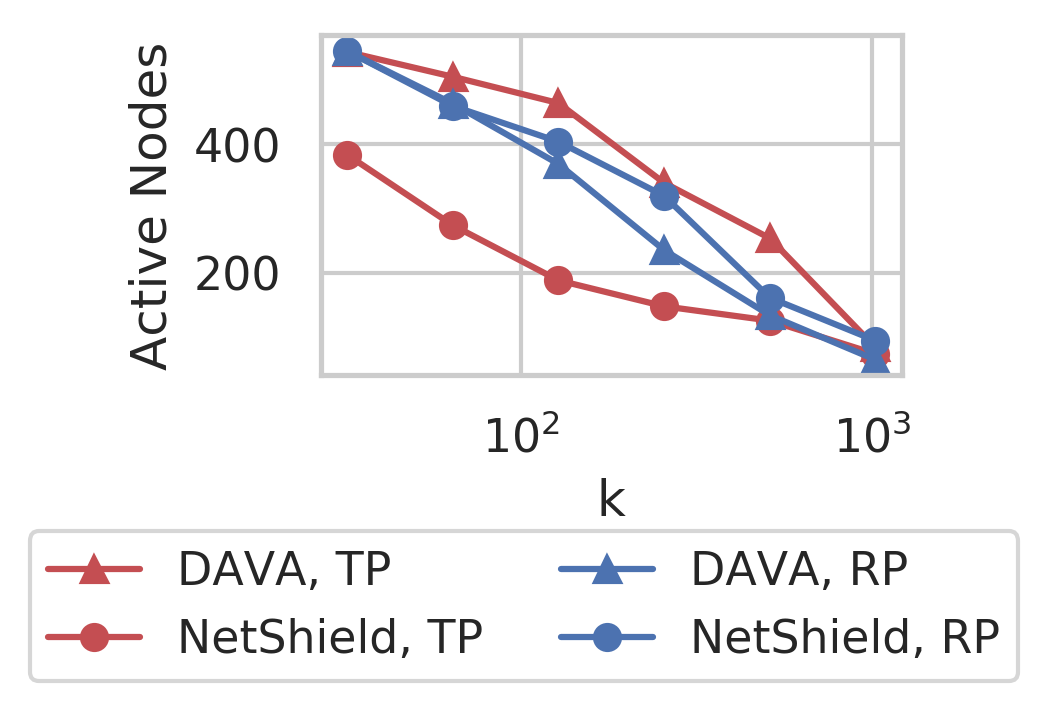

In [446]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_results2[:,0], all_results2[:,1], label="DAVA, TP",marker='^', color=clrs[3])
plt.semilogx(all_results2[:,0], all_results2[:,2], label="NetShield, TP",marker='o', color=clrs[3])
plt.semilogx(all_results[:,0], all_results[:,1], label="DAVA, RP",marker='^', color=clrs[0])
plt.semilogx(all_results[:,0], all_results[:,2], label="NetShield, RP",marker='o', color=clrs[0])
plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("k")
plt.ylabel("Active Nodes")

In [282]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_fake_seq.pkl'))
seeds = seeds_for_ba_fake[:100]
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_results3 = []
for k in tqdm([32, 64, 128, 256, 512, 1024]):
    netshield = NetShieldSolver(g,k=k,seeds=seeds)
    domsolver = DomSolver(g,k=k,seeds=seeds)
    netshield.run()
    domsolver.run()
    
    r = [k]
    for blocked_nodes in [domsolver.log['Blocked nodes'], netshield.log['Blocked nodes']]:
        g1 = g.copy()
        g1.remove_nodes_from(blocked_nodes)
        g1 = nx.convert_node_labels_to_integers(g1)
        a = dict([(n, True) for n in seeds])
        nx.set_node_attributes(g1, a, 'seed')
        with open(seed_path,"w") as f:
            for n in g1.nodes(data=True):
                if 'seed' in n[1]:
                    f.write('{}\n'.format(n[0]))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'attributes.txt'),"w") as f:
            f.write('n={}\nm={}\ngraph_id=0'.format(g1.number_of_nodes(), g1.number_of_edges()))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'graph.csv'),"w") as f:
            for e in g1.edges(data=True):
                f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

        graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp5')
        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append(result)
    all_results3.append(r)
all_results3 = np.array(all_results3)

100%|██████████| 6/6 [02:42<00:00, 35.50s/it]


In [283]:
g = nx.read_gpickle(os.path.join(config['general']['DataPath'], 'vk_graph_power_real.pkl'))
seeds = seeds_for_ba_real[:100]
seed_path = os.path.join(config['general']['DataPath'], 'tmp_seeds.txt')

all_results4 = []
for k in tqdm([32, 64, 128, 256, 512, 1024]):
    netshield = NetShieldSolver(g,k=k,seeds=seeds)
    domsolver = DomSolver(g,k=k,seeds=seeds)
    netshield.run()
    domsolver.run()
    
    r = [k]
    for blocked_nodes in [domsolver.log['Blocked nodes'], netshield.log['Blocked nodes']]:
        g1 = g.copy()
        g1.remove_nodes_from(blocked_nodes)
        g1 = nx.convert_node_labels_to_integers(g1)
        a = dict([(n, True) for n in seeds])
        nx.set_node_attributes(g1, a, 'seed')
        with open(seed_path,"w") as f:
            for n in g1.nodes(data=True):
                if 'seed' in n[1]:
                    f.write('{}\n'.format(n[0]))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'attributes.txt'),"w") as f:
            f.write('n={}\nm={}\ngraph_id=0'.format(g1.number_of_nodes(), g1.number_of_edges()))
        with open(os.path.join(config['general']['DataPath'], 'graph_tmp5', 'graph.csv'),"w") as f:
            for e in g1.edges(data=True):
                f.write('{} {} {}\n'.format(e[0], e[1], e[2]['weight']))

        graph_path = os.path.join(config['general']['DataPath'], 'graph_tmp5')
        result = subprocess.run(["/home/alvis/robust/src/SatGreedy/build/Simulator", "-dataset", graph_path, "-seeds", seed_path, "-iter", "1000"], capture_output=True)
        result = float(re.match(r".*\n([0-9\.]+), ([0-9\.]+)\n.*", result.stdout.decode()).group(1))
        r.append(result)
    all_results4.append(r)
all_results4 = np.array(all_results4)

100%|██████████| 6/6 [02:45<00:00, 34.85s/it]


Text(0, 0.5, 'Active Nodes')

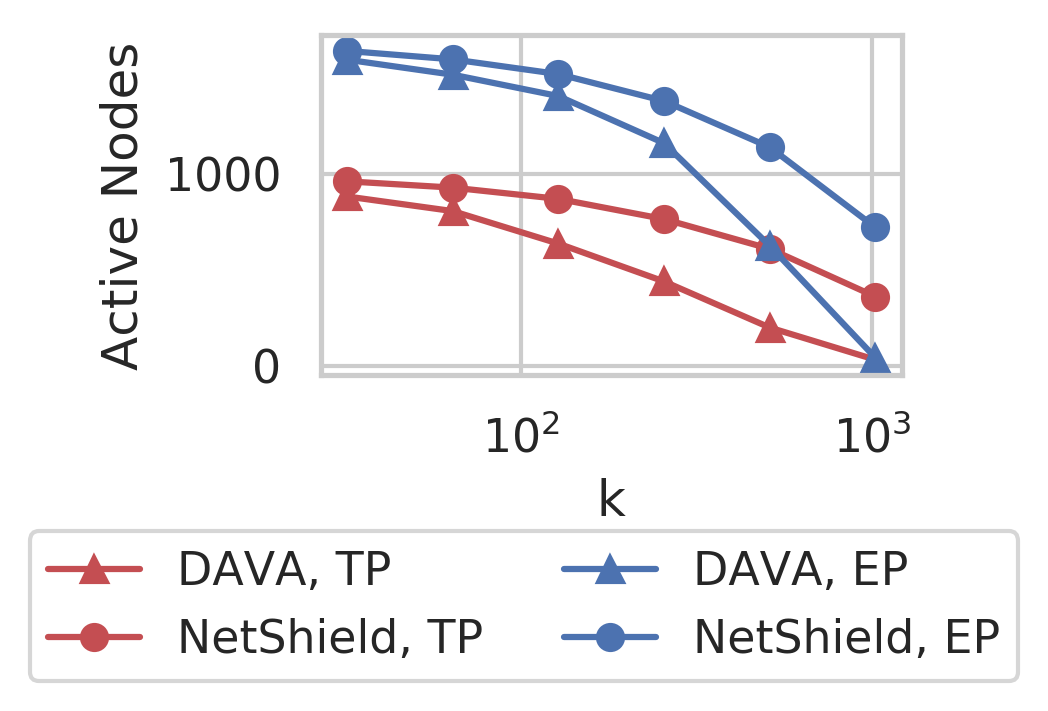

In [445]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_results3[:,0], all_results3[:,1], label="DAVA, TP",marker='^', color=clrs[3])
plt.semilogx(all_results3[:,0], all_results3[:,2], label="NetShield, TP",marker='o', color=clrs[3])
plt.semilogx(all_results4[:,0], all_results4[:,1], label="DAVA, EP",marker='^', color=clrs[0])
plt.semilogx(all_results4[:,0], all_results4[:,2], label="NetShield, EP",marker='o', color=clrs[0])
plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("k")
plt.ylabel("Active Nodes")

Text(0, 0.5, '$\\Delta_{\\mathit{rel}}$')

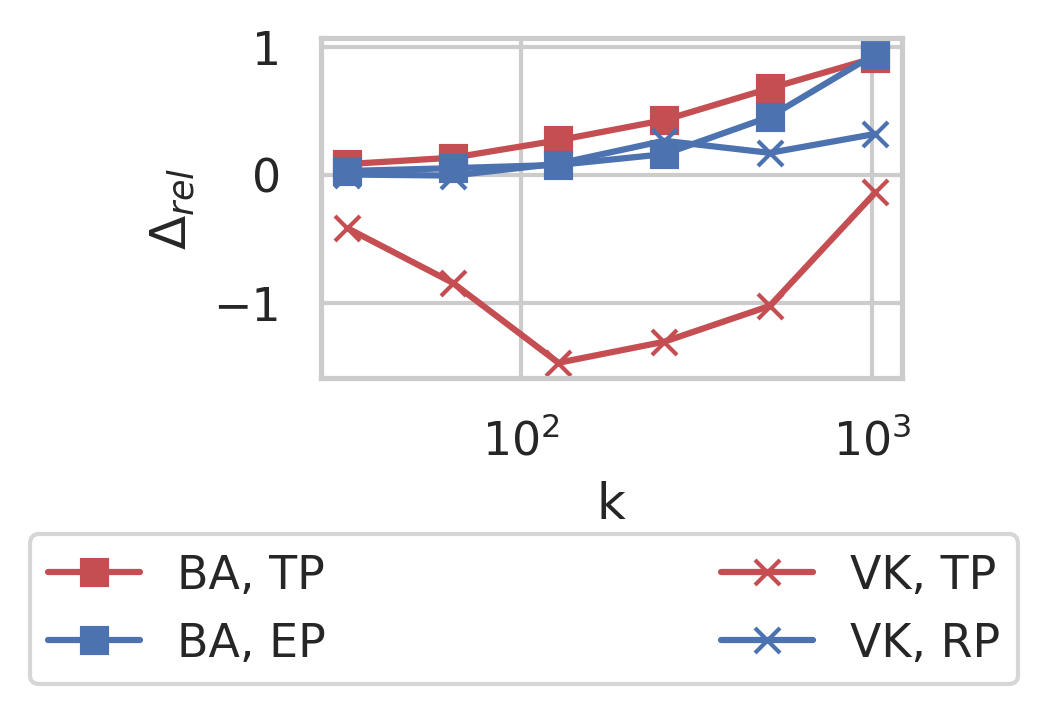

In [450]:
sns.set(rc={'figure.dpi':300,'figure.figsize':(2.5,1.5)},style="whitegrid",font_scale=1)
plt.semilogx(all_results3[:,0], (-all_results3[:,1]+all_results3[:,2])/all_results3[:,2], label="BA, TP",marker='s', color=clrs[3])
plt.semilogx(all_results4[:,0], (-all_results4[:,1]+all_results4[:,2])/all_results4[:,2], label="BA, EP",marker='s', color=clrs[0])
plt.semilogx(all_results2[:,0], (-all_results2[:,1]+all_results2[:,2])/all_results2[:,2], label="VK, TP",marker='x', color=clrs[3])
plt.semilogx(all_results[:,0], (-all_results[:,1]+all_results[:,2])/all_results[:,2], label="VK, RP",marker='x', color=clrs[0])

plt.legend(bbox_to_anchor=(-0.5, -0.9, 1.7, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel("k")
# plt.xlim((15,10**3))
# plt.ylim((-1,3))
plt.ylabel("$\Delta_{\mathit{rel}}$")

In [453]:
pkl.dump(all_results, open(os.path.join(config['general']['DataPath'], 'all_results.pkl'), 'wb'))
pkl.dump(all_results2, open(os.path.join(config['general']['DataPath'], 'all_results2.pkl'), 'wb'))
pkl.dump(all_results3, open(os.path.join(config['general']['DataPath'], 'all_results3.pkl'), 'wb'))
pkl.dump(all_results4, open(os.path.join(config['general']['DataPath'], 'all_results4.pkl'), 'wb'))

pkl.dump(all_result, open(os.path.join(config['general']['DataPath'], 'all_result.pkl'), 'wb'))
pkl.dump(all_result2, open(os.path.join(config['general']['DataPath'], 'all_result2.pkl'), 'wb'))
pkl.dump(all_result3, open(os.path.join(config['general']['DataPath'], 'all_result3.pkl'), 'wb'))
pkl.dump(all_result4, open(os.path.join(config['general']['DataPath'], 'all_result4.pkl'), 'wb'))